**Modèles épidémiologiques**
-

**Bárbara Barsi Duarte Batista da Silva**

**Rafaela de Carvalho Machado Pinheiro**


--- 

## Contexte
Il s'agit de voir les différences entre le modèle markovien et le modèle déterministe de la diffusion d'une épidémie. Vous devez rendre un fichier unique soit en pdf, soit en ipynb.

## Ce que vous avez à faire
- Ecrire un code qui résout et affiche le système déterministe SIR, prenant en entrée les paramètres beta et gamma (voir poly) 
- qui simule l'évolution du processus de Markov pour une population de N individus avec les mêmes paramètres beta et gamma
- Trouver des couples de valeurs (beta,gamma) où
    - tout le monde est retiré sur le long terme
    - il y a une partie de la population qui reste susceptible et une autre qui est retirée
- Illustrer sur des graphiques la convergence du processus de Markov renormalisé vers la solution du système déterministe


### Markov Model

### SIR Model
The SIR abbreviation stands for "Susceptible, Infected, Recovered/Removed", 
The deterministic SIR is a system of Ordinary Differential Equations:  
$$
\frac{dS}{dt} = -\beta S I
$$
$$
\frac{dI}{dt} = \beta S I - \gamma I
$$
$$
\frac{dR}{dt} = \gamma I
$$
Where:

- $S$: susceptible
- $I$: infected
- $R$: recovered (or removed)
- $\beta$: infection rate
- $\gamma$: recovery rate

<div class = 'alert alert-success'> 
Explicar os parametros gama e beta
</div>

In [108]:
def deriv_sir(y, t, N, beta, gamma):
    S, I, _ = y
    dSdt = -beta * S * I/N
    dIdt = beta * S * I/N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [ ]:
from scipy.integrate import odeint
import numpy as np
def SIR(beta, gamma, N):
    S0 = N - 1
    I0 = 1
    R0 = 0
    t = np.linspace(0, 160, 160)
    y = S0, I0, R0
    res = odeint(deriv_sir, y, t, args=(N, beta, gamma)) # solve ODEs
    S, I, R = res.T
    return S, I, R


In [103]:
# plot simulation results
import matplotlib.pyplot as plt
def plot_sir(S, I, R, t):
    plt.figure(figsize=(10, 6))
    plt.plot(t, S, 'b', label='Susceptible')
    plt.plot(t, I, 'r', label='Infected')
    plt.plot(t, R, 'g', label='Recovered')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title('SIR Model Simulation')
    plt.legend()
    plt.grid()
    plt.show()

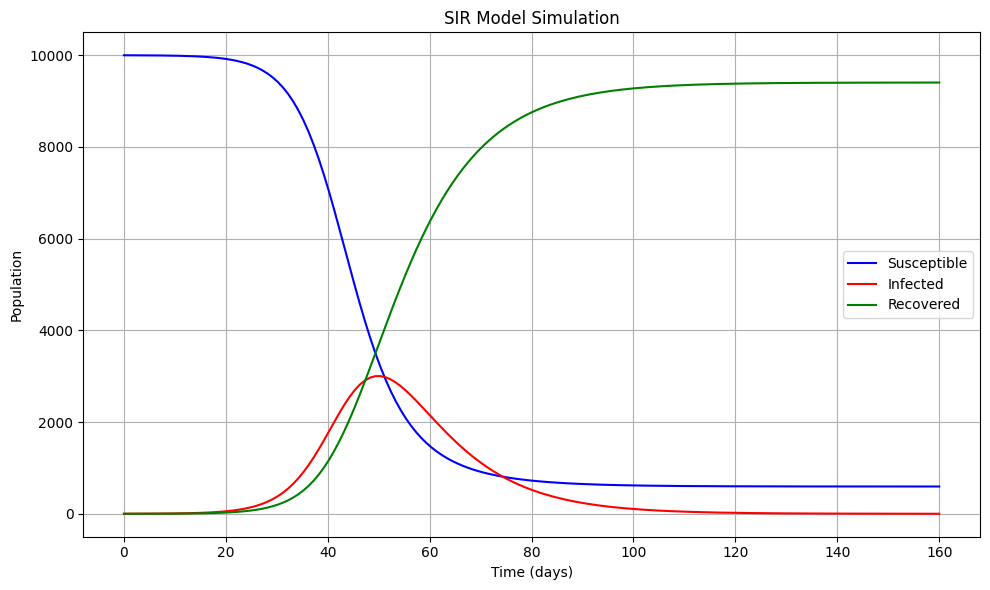

In [111]:
# run the simulation
beta = 0.3  # infection rate
gamma = 0.1  # recovery rate
N = 10000  # total population

S, I, R = SIR(beta, gamma, N)
t = np.linspace(0, 160, 160)
plot_sir(S, I, R, t)

---

### Question ouverte avec différentes réponses possibles 
A partir des données de Santé Publique France, <https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/>, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..." qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, **comment feriez-vous pour estimer gamma et beta sur un département donné ?**


### Code

In [57]:
import pandas as pd

data = pd.read_csv('donnees-covid.csv', sep=';')
print(data.head())

  dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
0   1  2020-03-19           1          0         0          0
1   1  2020-03-20           0          0         0          1
2   1  2020-03-21           3          0         0          0
3   1  2020-03-22           3          1         0          1
4   1  2020-03-23          14          1         0          5


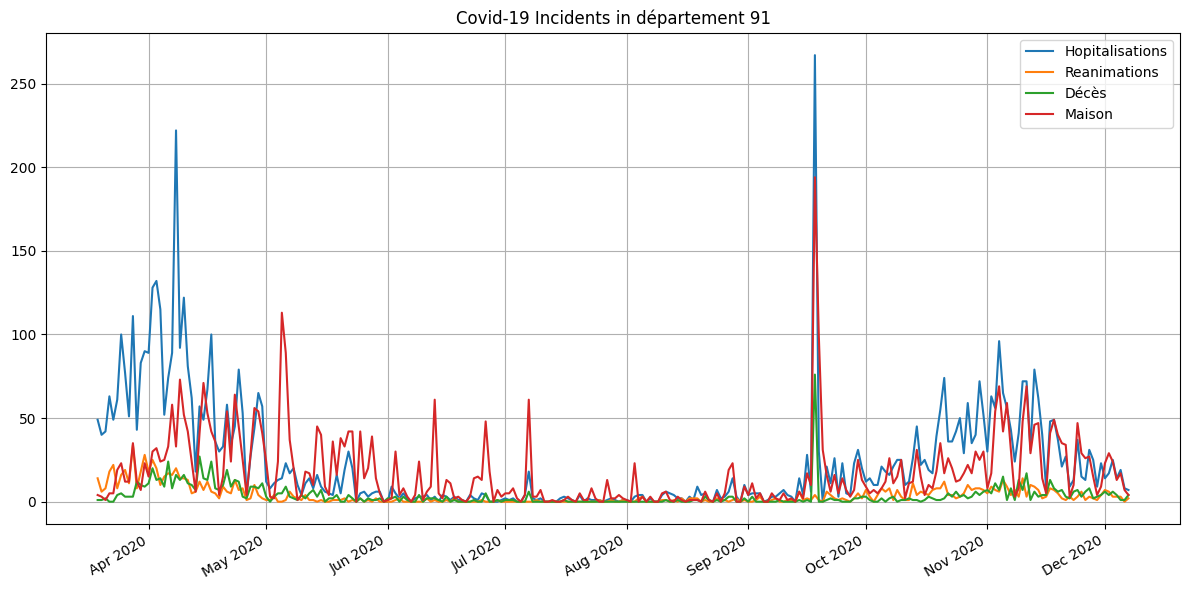

In [89]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dep = '91'

data_plot = data[['dep', 'jour', 'incid_hosp', 'incid_rea', 'incid_dc', 'incid_rad']].copy()
data_plot = data_plot[data_plot.dep == dep]
data_plot['jour'] = pd.to_datetime(data_plot['jour'], format='%Y-%m-%d')
data_plot.set_index('jour', inplace=True)
data_plot = data_plot.sort_index()
# data_plot = data_plot.resample('D').sum()

plt.figure(figsize=(12, 6))
plt.plot(data_plot.index, data_plot['incid_hosp'], label='Hopitalisations')
plt.plot(data_plot.index, data_plot['incid_rea'], label='Reanimations')
plt.plot(data_plot.index, data_plot['incid_dc'], label='Décès')
plt.plot(data_plot.index, data_plot['incid_rad'], label='Maison')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Mar 2020" etc
plt.gcf().autofmt_xdate()  


plt.title(f'Covid-19 Incidents in département {dep}')
plt.grid(True)
plt.legend()
plt.show()